# Model 3

CNN model as in modelID C134 as in Walsh et al. (2024).

## References
Walsh, J., Neupane, A., & Li, M. (2024). Evaluation of 1D convolutional neural network in estimation of mango dry matter content. Spectrochimica Acta Part A: Molecular and Biomolecular Spectroscopy, 311. https://doi.org/10.1016/j.saa.2024.124003

## Setup

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf

from utils import peval

KeyboardInterrupt: 

In [ ]:
# set random seeds for Python, NumPy, and TensorFlow
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [ ]:
# read in prepared dataset from previous step
df = pd.read_pickle("../../3_preprocessing/data/prepared/pretreatment_2_scaled_partition_1_outlier_flag_1.pkl").sort_values(by="sample_order_1")
x_cols = df.filter(regex="^\d+", axis=1).columns
descriptive_cols = [col for col in df.columns if col not in x_cols]
df

,partition,train_partition,subsequent_flag_1,sample_order_1,origin,population,date,season,region,cultivar,...,963_snv_savgol_d2,966_snv_savgol_d2,969_snv_savgol_d2,972_snv_savgol_d2,975_snv_savgol_d2,978_snv_savgol_d2,981_snv_savgol_d2,984_snv_savgol_d2,987_snv_savgol_d2,990_snv_savgol_d2
36003,train,calibration,0,0,nich,105400,2017-09-27,2017,NT,r2e2,...,-0.000603,-0.000565,-0.000515,-0.000467,-0.000356,-0.000237,-0.000125,-0.000130,-0.000273,-0.000444
45363,train,calibration,0,1,nich,107200,2017-10-23,2017,NT,r2e2,...,0.001371,0.001812,0.002154,0.002441,0.002271,0.002085,0.001865,0.001661,0.001503,0.001345
43757,train,calibration,0,3,nich,106800,2017-10-23,2017,NT,hg,...,0.001093,0.001602,0.002000,0.002354,0.002131,0.001945,0.001750,0.001543,0.001343,0.001191
23699,train,tunning,0,4,nich,103107,2016-10-14,2016,NT,r2e2,...,-0.003025,-0.003202,-0.003075,-0.002802,-0.002281,-0.001655,-0.001231,-0.001155,-0.001229,-0.001256
72520,validation,calibration,1,5,nich,112700,2019-03-09,2018,QLD,keitt,...,0.000973,0.000705,0.000423,0.000249,0.000166,0.000106,0.000110,0.000207,0.000318,0.000547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71544,validation,calibration,1,84966,nich,112500,2019-03-04,2018,QLD,caly,...,-0.003220,-0.003719,-0.003851,-0.003569,-0.003373,-0.003187,-0.002958,-0.002655,-0.002296,-0.001922
16397,train,calibration,0,84967,nich,102503,2016-09-03,2016,NT,kp,...,-0.003160,-0.001560,-0.000744,-0.000802,-0.001222,-0.001699,-0.001880,-0.001822,-0.001587,-0.001236
12562,train,tunning,0,84968,nich,101200,2015-11-02,2015,NT,caly,...,-0.000107,-0.000309,-0.000393,-0.000382,-0.000179,0.000012,-0.000116,-0.000063,0.000240,0.000370
58787,anderson_external_val,calibration,0,84969,published,109700,2018-08-07,2018,NT,caly,...,0.000692,0.000595,0.000477,0.000260,0.000142,0.000072,0.000052,0.000128,0.000072,0.000016


## Build Model

In [ ]:
# clear keras session
tf.keras.backend.clear_session()

# number of sample to train for each pass into the ANN
batch = 128

# learning rate
lr = 0.005

# input layer dimensions
input_dims = df[x_cols].shape[1]

# L2 regularisation parameter
reg_beta = 0.011
beta = reg_beta/2.

# weights L2 regularization
kernel_reg = tf.keras.regularizers.l2(beta)

# weights initialisation (used for all layers for simplicity)
kernel_init = tf.keras.initializers.he_normal(seed=SEED_VALUE)

# model architecture
model = tf.keras.Sequential(
    layers=[
        tf.keras.layers.Reshape(
            target_shape=(input_dims, 1),
            input_shape=(input_dims,)
        ),
        tf.keras.layers.Conv1D(
            filters=1,
            kernel_size=21,
            strides=1,
            padding="same",
            kernel_initializer=kernel_init,
            kernel_regularizer=kernel_reg,
            activation="elu",
            input_shape=(input_dims, 1)
        ),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(
            units=36,
            kernel_initializer=kernel_init,
            kernel_regularizer=kernel_reg,
            activation="elu"
        ),
        tf.keras.layers.Dense(
            units=18,
            kernel_initializer=kernel_init,
            kernel_regularizer=kernel_reg,
            activation="elu"
        ),
        tf.keras.layers.Dense(
            units=12,
            kernel_initializer=kernel_init,
            kernel_regularizer=kernel_reg,
            activation="elu"
        ),
        tf.keras.layers.Dense(
            units=1,
            kernel_initializer=kernel_init,
            kernel_regularizer=kernel_reg,
            activation="linear"
        ),
    ]
)

# compile model with adam optimiser
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="mse",
    metrics=["mse"]
)

In [ ]:
# reduce learning rate dynamically
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=25,
    factor=0.5,
    min_lr=10**-6,
    monitor="val_loss",
    verbose=0
)

# early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=10**-5,
    patience=50,
    mode="auto",
    restore_best_weights=True
)

In [ ]:
df_cal = df.query("partition == 'train' and train_partition == 'calibration'")
df_tune = df.query("partition == 'train' and train_partition == 'tunning'")

history = model.fit(
    x=df_cal[x_cols],
    y=df_cal["dry_matter"],
    batch_size=batch,
    epochs=10000,
    validation_data=(df_tune[x_cols], df_tune["dry_matter"]),
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/10000


526/526 [==============================] - 3s 4ms/step - loss: 8.5180 - mse: 7.8828 - val_loss: 5.8745 - val_mse: 5.3656 - lr: 0.0050
Epoch 2/10000
526/526 [==============================] - 2s 3ms/step - loss: 5.1317 - mse: 4.6440 - val_loss: 4.7976 - val_mse: 4.3126 - lr: 0.0050
Epoch 3/10000
526/526 [==============================] - 2s 3ms/step - loss: 4.2683 - mse: 3.7596 - val_loss: 3.6279 - val_mse: 3.0840 - lr: 0.0050
Epoch 4/10000
526/526 [==============================] - 2s 3ms/step - loss: 3.1846 - mse: 2.6209 - val_loss: 3.0368 - val_mse: 2.4669 - lr: 0.0050
Epoch 5/10000
526/526 [==============================] - 2s 4ms/step - loss: 2.6275 - mse: 2.0727 - val_loss: 2.6220 - val_mse: 2.0801 - lr: 0.0050
Epoch 6/10000
526/526 [==============================] - 2s 4ms/step - loss: 2.3573 - mse: 1.8344 - val_loss: 2.0432 - val_mse: 1.5353 - lr: 0.0050
Epoch 7/10000
526/526 [==============================] - 2s 3ms/step - loss: 2.2594 - mse: 1.7623 - val_loss: 

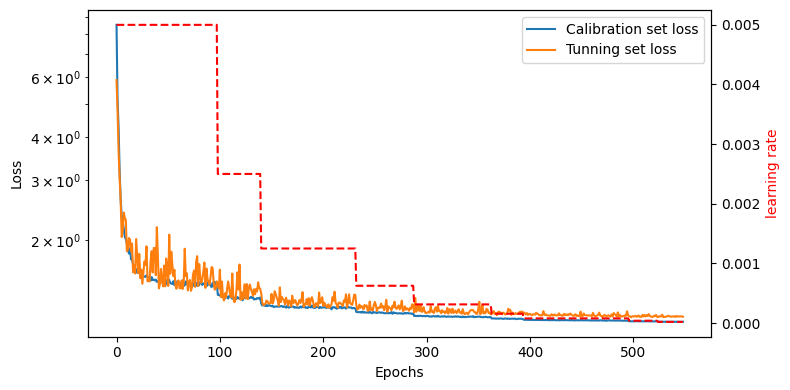

In [ ]:
peval.plot_model_history(history.history)

## Test Model

In [ ]:
df_preds = df[descriptive_cols].copy()
df_preds["y_true"] = df_preds["dry_matter"]
df_preds["y_pred"] = model.predict(df[x_cols])
df_preds

2639/2639 [==============================] - 4s 1ms/step


,partition,train_partition,subsequent_flag_1,sample_order_1,origin,population,date,season,region,cultivar,physio_stage,temp,reference_no,dry_matter,instrument,spectra_no,y_true,y_pred
36003,train,calibration,0,0,nich,105400,2017-09-27,2017,NT,r2e2,green,undef,3287,12.327440,17033,36945,12.327440,13.097857
45363,train,calibration,0,1,nich,107200,2017-10-23,2017,NT,r2e2,green,undef,4039,14.638310,15016,46563,14.638310,13.886203
43757,train,calibration,0,3,nich,106800,2017-10-23,2017,NT,hg,green,undef,3876,15.665600,15016,44933,15.665600,14.523164
23699,train,tunning,0,4,nich,103107,2016-10-14,2016,NT,r2e2,ripen,undef,1919,15.031000,15023,24705,15.031000,14.812644
72520,validation,calibration,1,5,nich,112700,2019-03-09,2018,QLD,keitt,ripen,high,7667,16.867996,15006,80282,16.867996,17.083603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71544,validation,calibration,1,84966,nich,112500,2019-03-04,2018,QLD,caly,ripen,undef,7558,14.563697,18029,77214,14.563697,14.224478
16397,train,calibration,0,84967,nich,102503,2016-09-03,2016,NT,kp,ripen,undef,1271,17.370000,30004,17241,17.370000,17.071894
12562,train,tunning,0,84968,nich,101200,2015-11-02,2015,NT,caly,green,high,498,18.820072,15023,13824,18.820072,18.187325
58787,anderson_external_val,calibration,0,84969,published,109700,2018-08-07,2018,NT,caly,ripen,undef,5341,17.306802,15006,60441,17.306802,17.816481


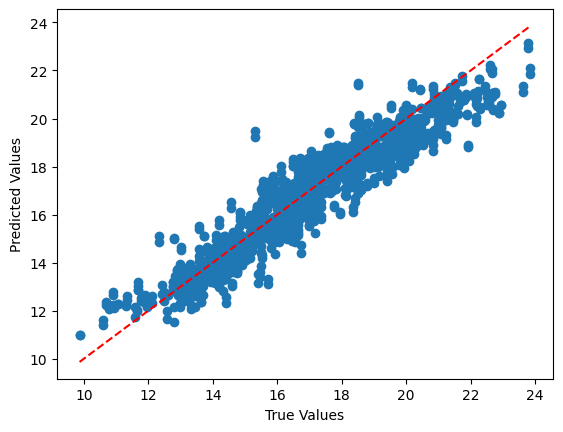

{'n': 1448,
 'r2': 0.8904163199479619,
 'rmse': 0.8833959471353846,
 'sep': 0.8644120111838522,
 'bias': 0.18356552521375186,
 'rpd': 3.088244556132472}

In [ ]:
test_partition = df_preds.query("partition == 'validation'")
metrics = peval.calculate_metrics(y_true=test_partition["y_true"], y_pred=test_partition["y_pred"])
metrics

## Output predictions and metrics

In [ ]:
df_preds.to_pickle(f"data/predictions/model_3.pkl")
with open(f"data/metrics/model_3.pkl", "wb") as f:
    pickle.dump(metrics, f)